In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [98]:
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from collections import Counter

In [99]:
dataset_file = '../datasets/Carseats.csv'
seed = 1

data = pd.read_csv(dataset_file)
data.Urban = data.Urban.apply(lambda v: 1 if v == 'Yes' else 0)
data.US = data.US.apply(lambda v: 1 if v == 'Yes' else 0)
data = pd.concat([data, pd.get_dummies(data.ShelveLoc, prefix='ShelveLoc', prefix_sep='')], axis=1)
data.drop(['ShelveLoc'], axis=1, inplace=True)
data['High'] = data.Sales.apply(lambda v: 1 if v > 8 else 0)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban,US,ShelveLocBad,ShelveLocGood,ShelveLocMedium,High
0,9.50,138,73,11,276,120,42,17,1,1,1,0,0,1
1,11.22,111,48,16,260,83,65,10,1,1,0,1,0,1
2,10.06,113,35,10,269,80,59,12,1,1,0,0,1,1
3,7.40,117,100,4,466,97,55,14,1,1,0,0,1,0
4,4.15,141,64,3,340,128,38,13,1,0,1,0,0,0


In [100]:
model = tree.DecisionTreeClassifier(random_state=seed, max_leaf_nodes=27).fit(data.drop(['Sales', 'High'], axis=1), data.High)

In [101]:
leaves_count = Counter()
n1 = Counter()
n0 = Counter()
for X, y in zip(data.drop(['Sales', 'High'], axis=1).to_numpy(), data.High):
    terminal = model.apply(X.reshape(1, -1))[0]
    leaves_count[terminal] += 1
    if y == 1:
        n1[terminal] += 1
    else:
        n0[terminal] += 1

deviance = -2 * np.sum([n1[leaf] * np.log(n1[leaf] / leaves_count[leaf] + 1e-6) + \
                        n0[leaf] * np.log(n0[leaf] / leaves_count[leaf] + 1e-6) 
                        for leaf in leaves_count.keys()])

Terminal nodes: 27
Training error: 0.0700
Mean deviance: 0.4636


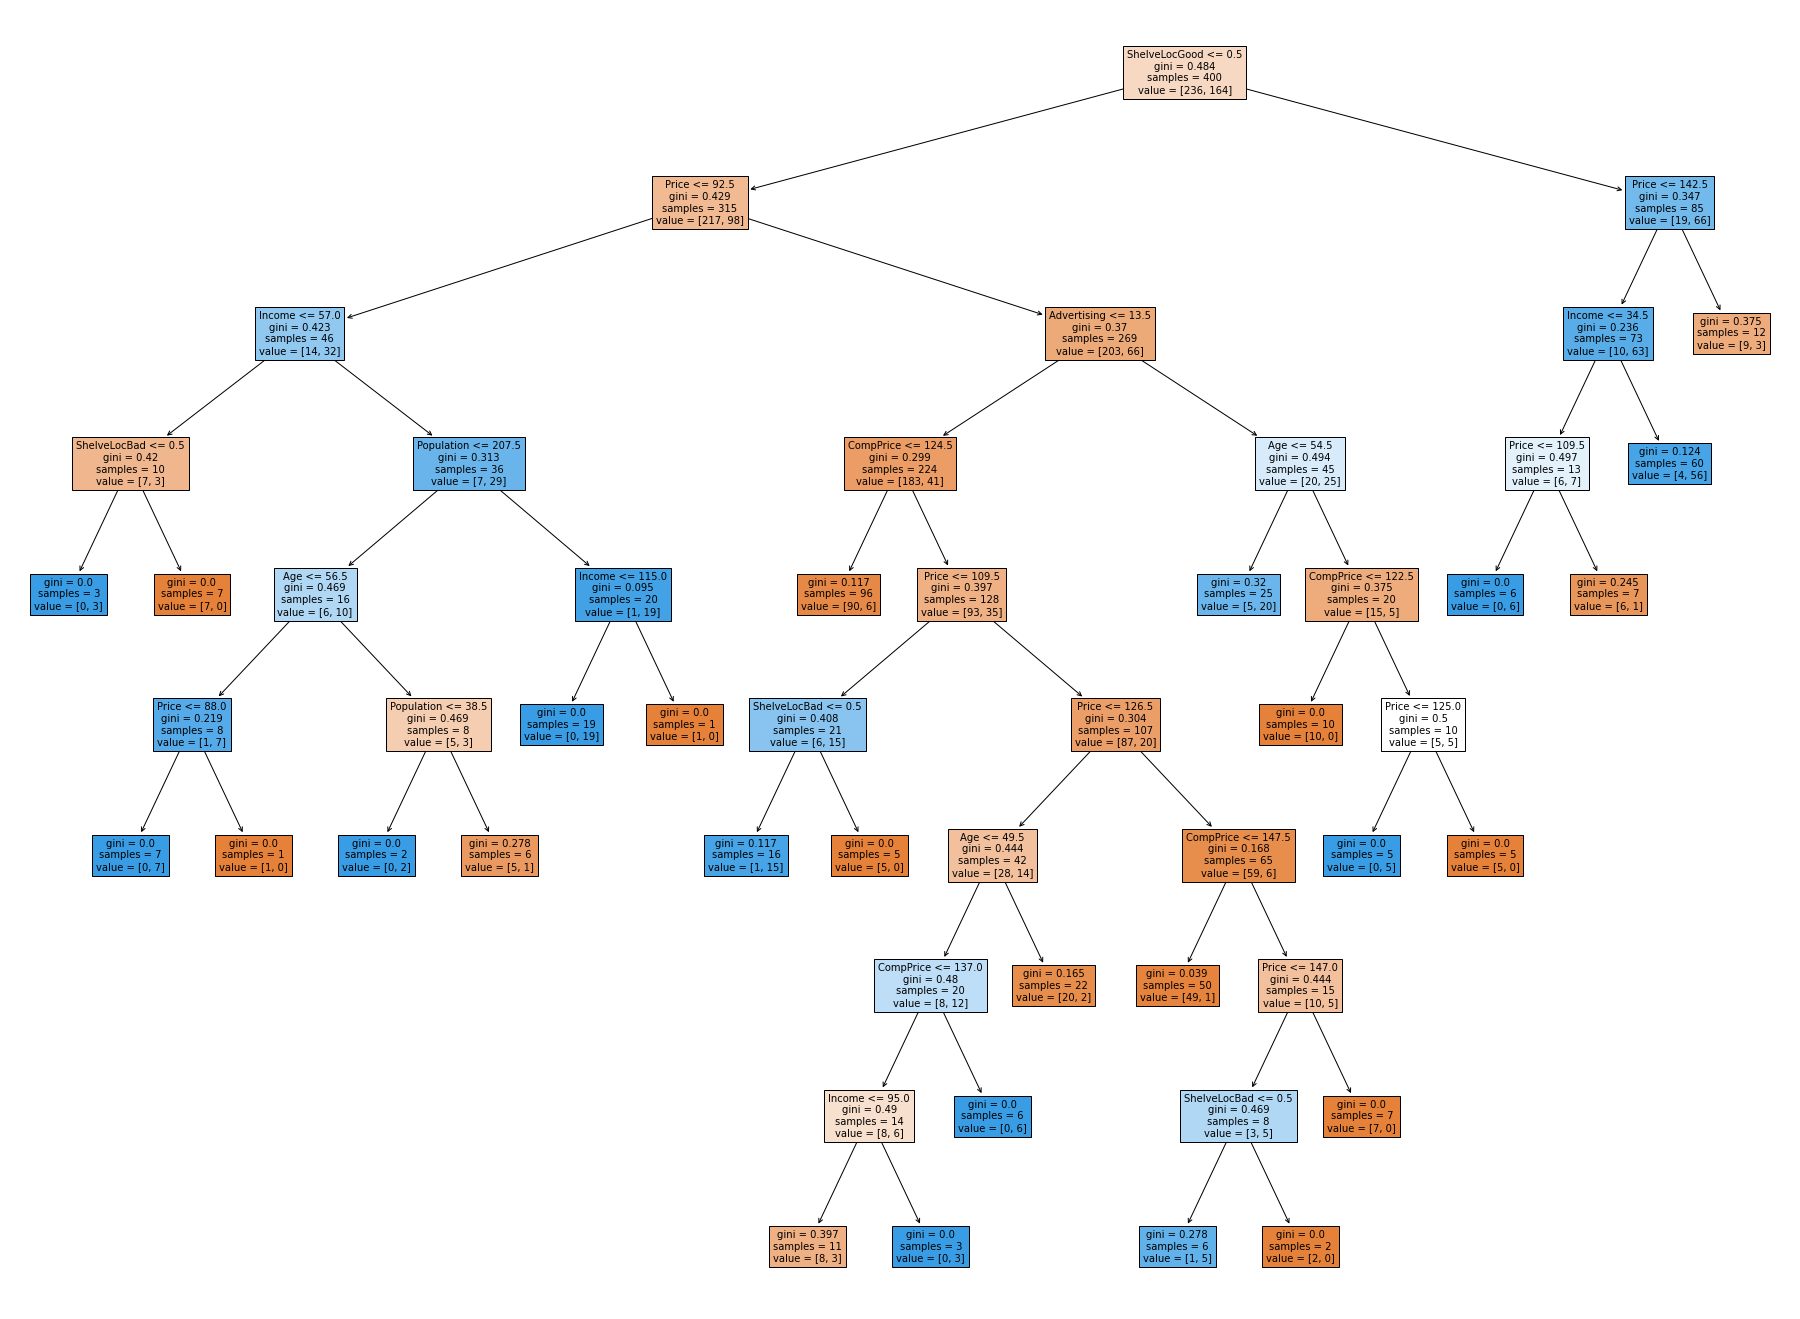

In [102]:
plt.figure(figsize=(32, 24))
cols = data.drop(['Sales', 'High'], axis=1).columns
tree.plot_tree(model, feature_names=cols, filled=True)
print(f'Terminal nodes: {model.get_n_leaves()}')
print(f"Training error: {1 - model.score(data.drop(['Sales', 'High'], axis=1), data.High):.4f}")
print(f"Mean deviance: {deviance / (data.High.size - model.max_leaf_nodes):.4f}")

In [103]:
print(tree.export_text(model, feature_names=list(cols)))

|--- ShelveLocGood <= 0.50
|   |--- Price <= 92.50
|   |   |--- Income <= 57.00
|   |   |   |--- ShelveLocBad <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- ShelveLocBad >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Income >  57.00
|   |   |   |--- Population <= 207.50
|   |   |   |   |--- Age <= 56.50
|   |   |   |   |   |--- Price <= 88.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Price >  88.00
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Age >  56.50
|   |   |   |   |   |--- Population <= 38.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Population >  38.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- Population >  207.50
|   |   |   |   |--- Income <= 115.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Income >  115.00
|   |   |   |   |   |--- class: 0
|   |--- Price >  92.50
|   |   |--- Advertising <= 13.50
|   |   |   |--- CompPrice <= 124.50
|   |   |   |   |--- class: 0
|   |   |   |--- Com

In [104]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score

In [105]:
train_data, test_data = train_test_split(data, test_size=.25, random_state=seed)

train_X, test_X = train_data.drop(['Sales', 'High'], axis=1), test_data.drop(['Sales', 'High'], axis=1)
train_y, test_y = train_data.High, test_data.High

In [106]:
model = tree.DecisionTreeClassifier(random_state=seed).fit(train_X, train_y)
pred_y = model.predict(test_X)

cmx = confusion_matrix(test_y, pred_y).T
acc = accuracy_score(test_y, pred_y)

print(f'TN: {cmx[0, 0]}, FN: {cmx[0, 1]}, FP: {cmx[1, 0]}, TP: {cmx[1, 1]}')
print(f'Accuracy score: {acc}')

TN: 48, FN: 15, FP: 13, TP: 24
Accuracy score: 0.72


Text(0, 0.5, 'Accuracy')

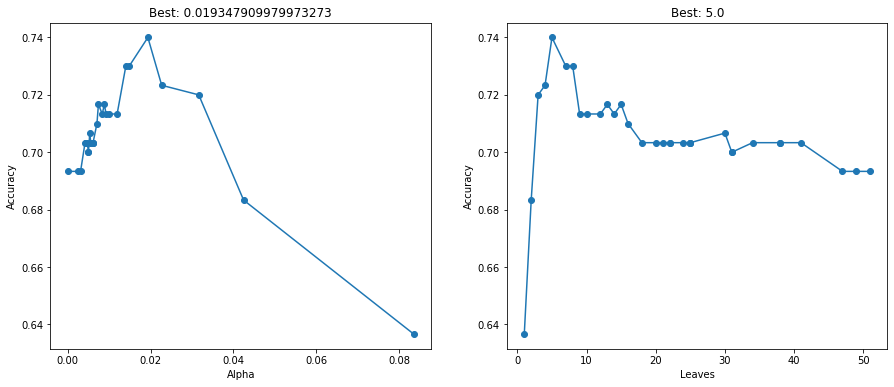

In [113]:
alphas = model.cost_complexity_pruning_path(train_X, train_y)['ccp_alphas']
train_scores = pd.DataFrame(
    dtype=float,
    index=pd.RangeIndex(len(alphas)),
    columns=['alpha', 'mean', 'std', 'leaves']
)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for idx, alpha in enumerate(alphas):
    model = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=alpha)
    model.fit(train_X, train_y)
    leaves = model.get_n_leaves()
    scores = cross_val_score(model, train_X, train_y, cv=cv)
    train_scores.iloc[idx] = alpha, scores.mean(), scores.std(), leaves

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
best = train_scores['mean'].idxmax()

axes[0].plot(train_scores.alpha, train_scores['mean'], 'o-')
axes[0].set_title(f"Best: {train_scores.iloc[best].alpha}")
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Accuracy')

axes[1].plot(train_scores.leaves, train_scores['mean'], 'o-')
axes[1].set_title(f"Best: {train_scores.loc[best].leaves}")
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('Accuracy')

TN: 47, FN: 14, FP: 14, TP: 25
Accuracy score: 0.72
Leaves: 5


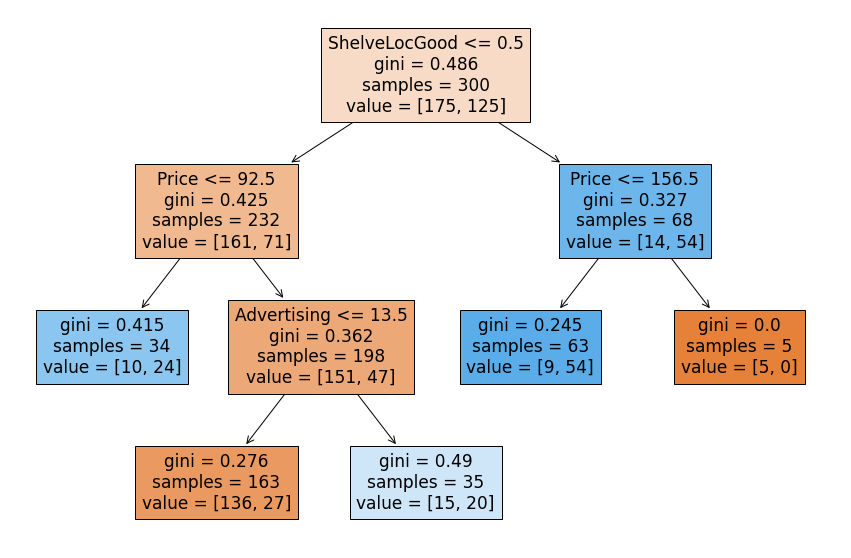

In [115]:
best_model = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=train_scores.iloc[best].alpha)
best_model.fit(train_X, train_y)
pred_y = best_model.predict(test_X)

cmx = confusion_matrix(test_y, pred_y).T
acc = accuracy_score(test_y, pred_y)

plt.figure(figsize=(15, 10))
tree.plot_tree(best_model, feature_names=cols, filled=True)

print(f'TN: {cmx[0, 0]}, FN: {cmx[0, 1]}, FP: {cmx[1, 0]}, TP: {cmx[1, 1]}')
print(f'Accuracy score: {acc}')
print(f'Leaves: {best_model.get_n_leaves()}')

In [116]:
from sklearn.metrics import mean_squared_error

In [117]:
dataset_file = '../datasets/Boston.csv'

data = pd.read_csv(dataset_file)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [120]:
model = tree.DecisionTreeRegressor(random_state=seed, max_leaf_nodes=8).fit(data.drop(['medv'], axis=1), data.medv)

Terminal nodes: 8
Training error: 0.1615
Mean deviance: 13.8513


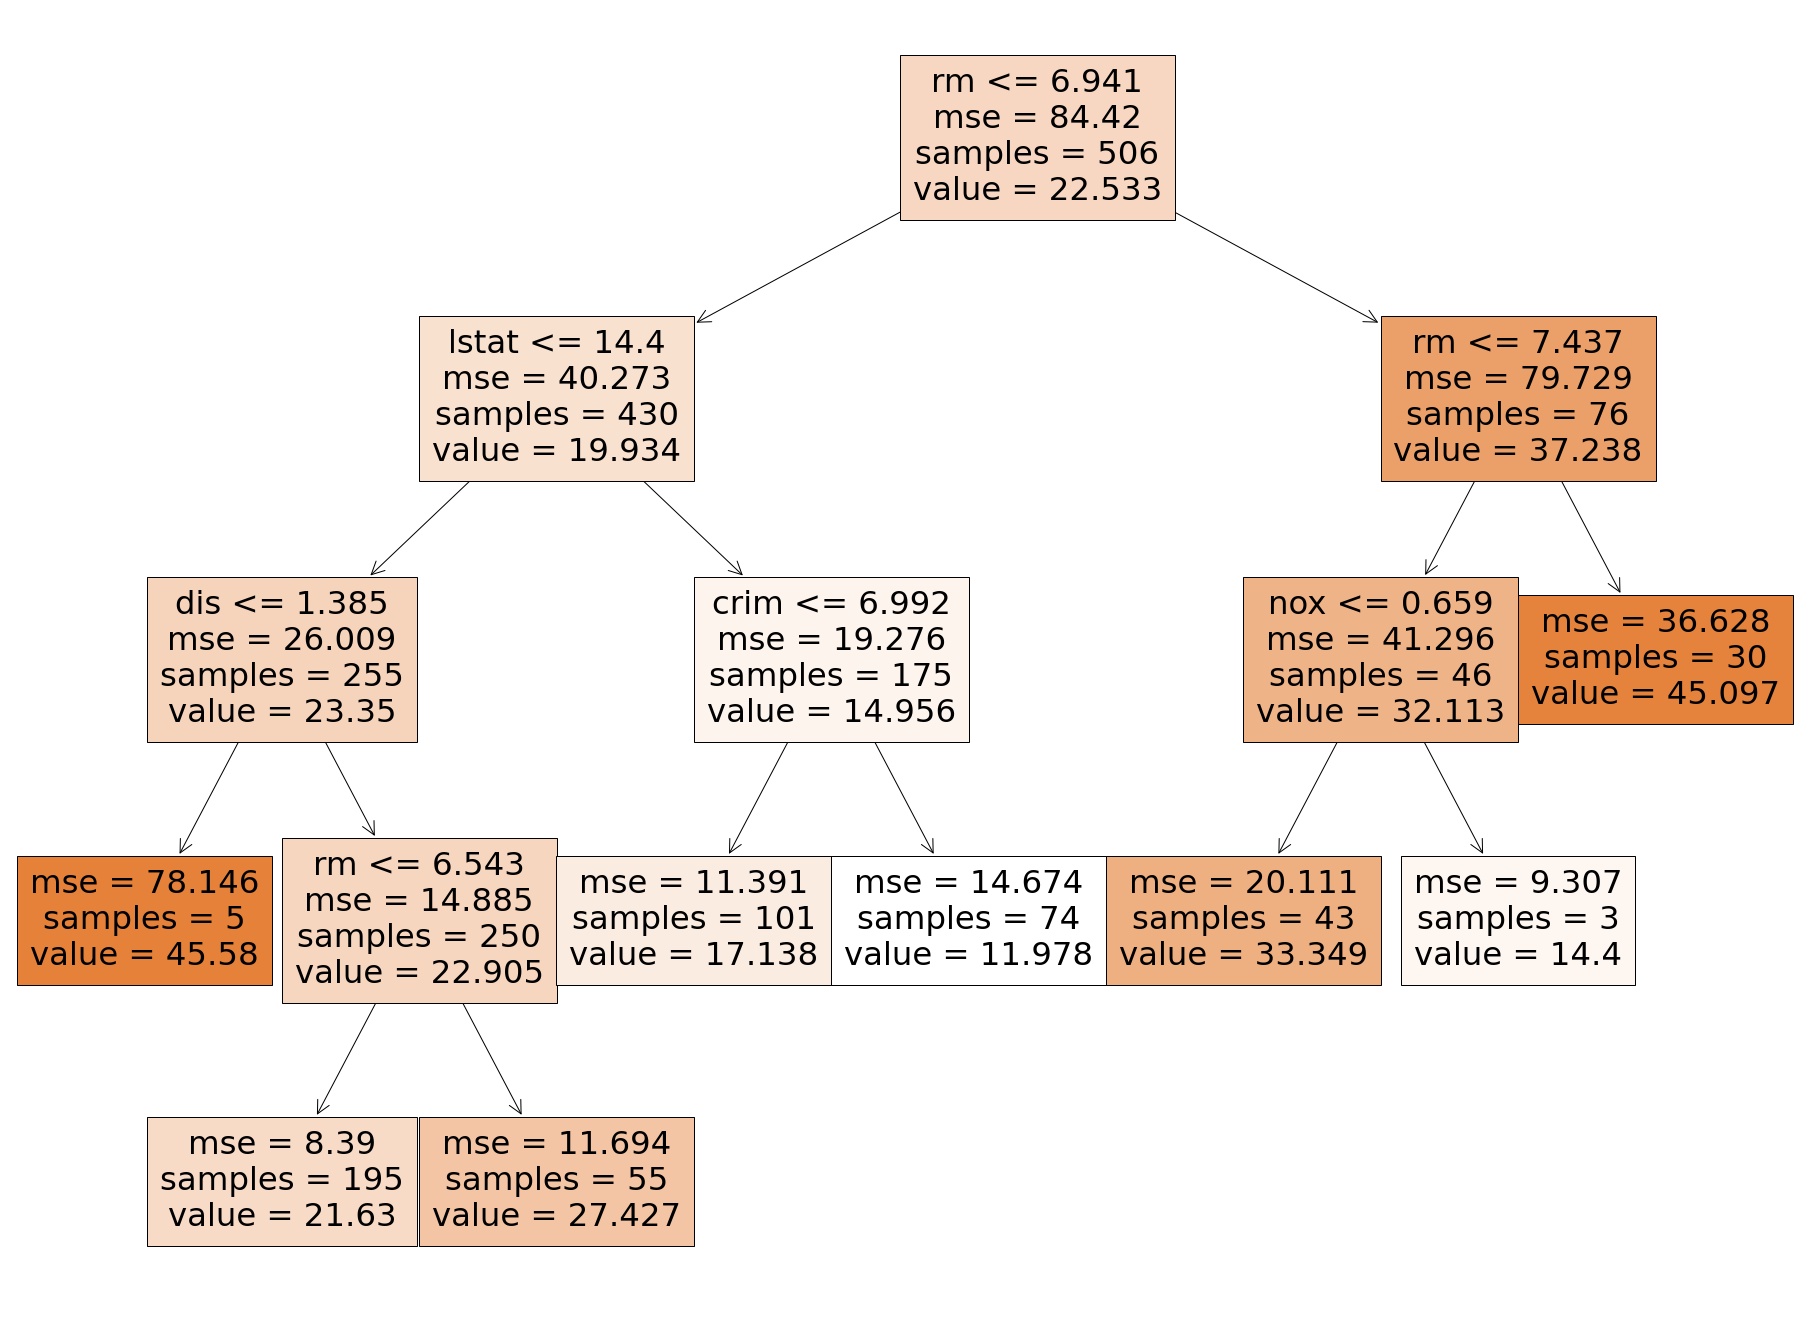

In [121]:
plt.figure(figsize=(32, 24))
cols = data.drop(['medv'], axis=1).columns
tree.plot_tree(model, feature_names=cols, filled=True)

deviance = ((data.medv - model.predict(data.drop(['medv'], axis=1))) ** 2).sum()
print(f'Terminal nodes: {model.get_n_leaves()}')
print(f"Training error: {1 - model.score(data.drop(['medv'], axis=1), data.medv):.4f}")
print(f"Mean deviance: {deviance / (data.medv.size - model.max_leaf_nodes):.4f}")

In [122]:
print(tree.export_text(model, feature_names=list(cols)))

|--- rm <= 6.94
|   |--- lstat <= 14.40
|   |   |--- dis <= 1.38
|   |   |   |--- value: [45.58]
|   |   |--- dis >  1.38
|   |   |   |--- rm <= 6.54
|   |   |   |   |--- value: [21.63]
|   |   |   |--- rm >  6.54
|   |   |   |   |--- value: [27.43]
|   |--- lstat >  14.40
|   |   |--- crim <= 6.99
|   |   |   |--- value: [17.14]
|   |   |--- crim >  6.99
|   |   |   |--- value: [11.98]
|--- rm >  6.94
|   |--- rm <= 7.44
|   |   |--- nox <= 0.66
|   |   |   |--- value: [33.35]
|   |   |--- nox >  0.66
|   |   |   |--- value: [14.40]
|   |--- rm >  7.44
|   |   |--- value: [45.10]



In [123]:
train_data, test_data = train_test_split(data, test_size=.25, random_state=seed)

train_X, test_X = train_data.drop(['medv'], axis=1), test_data.drop(['medv'], axis=1)
train_y, test_y = train_data.medv, test_data.medv

In [128]:
model = tree.DecisionTreeRegressor(random_state=seed).fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

MSE: 20.6033


In [131]:
def mse_scoring(est, X, y):
    return mean_squared_error(y, est.predict(X))

Text(0, 0.5, 'MSE')

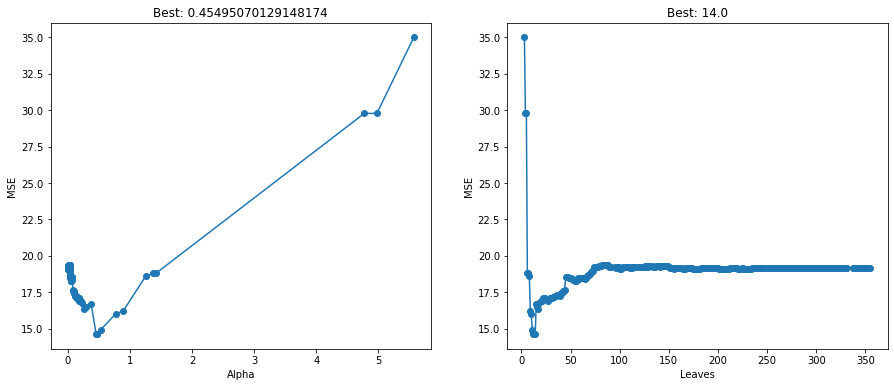

In [139]:
alphas = model.cost_complexity_pruning_path(train_X, train_y)['ccp_alphas'][:-2]
train_scores = pd.DataFrame(
    dtype=float,
    index=pd.RangeIndex(len(alphas)),
    columns=['alpha', 'mean', 'std', 'leaves']
)
cv = KFold(n_splits=5, shuffle=True, random_state=seed)

for idx, alpha in enumerate(alphas):
    model = tree.DecisionTreeRegressor(random_state=seed, ccp_alpha=alpha)
    model.fit(train_X, train_y)
    leaves = model.get_n_leaves()
    scores = cross_val_score(model, train_X, train_y, scoring=mse_scoring, cv=cv)
    train_scores.iloc[idx] = alpha, scores.mean(), scores.std(), leaves

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
best = train_scores['mean'].idxmin()

axes[0].plot(train_scores.alpha, train_scores['mean'], 'o-')
axes[0].set_title(f"Best: {train_scores.iloc[best].alpha}")
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('MSE')

axes[1].plot(train_scores.leaves, train_scores['mean'], 'o-')
axes[1].set_title(f"Best: {train_scores.loc[best].leaves}")
axes[1].set_xlabel('Leaves')
axes[1].set_ylabel('MSE')

MSE: 11.5085
Leaves: 14


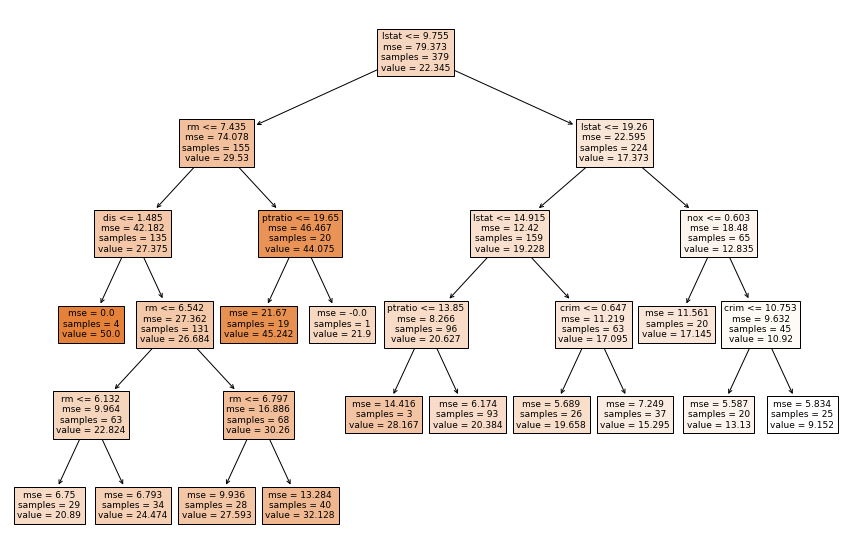

In [140]:
best_model = tree.DecisionTreeRegressor(random_state=seed, ccp_alpha=train_scores.iloc[best].alpha)
best_model.fit(train_X, train_y)
pred_y = best_model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

plt.figure(figsize=(15, 10))
tree.plot_tree(best_model, feature_names=cols, filled=True)

print(f'MSE: {mse:.4f}')
print(f'Leaves: {best_model.get_n_leaves()}')

In [141]:
from sklearn import ensemble

In [159]:
model = ensemble.BaggingRegressor(random_state=seed, n_estimators=500)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

MSE: 8.7811


In [161]:
model = ensemble.BaggingRegressor(random_state=seed, n_estimators=25)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

MSE: 8.8555


In [162]:
model = ensemble.RandomForestRegressor(random_state=seed, n_estimators=500, max_features='sqrt')
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

MSE: 10.9908


Text(0.5, 1.0, 'Feature importances')

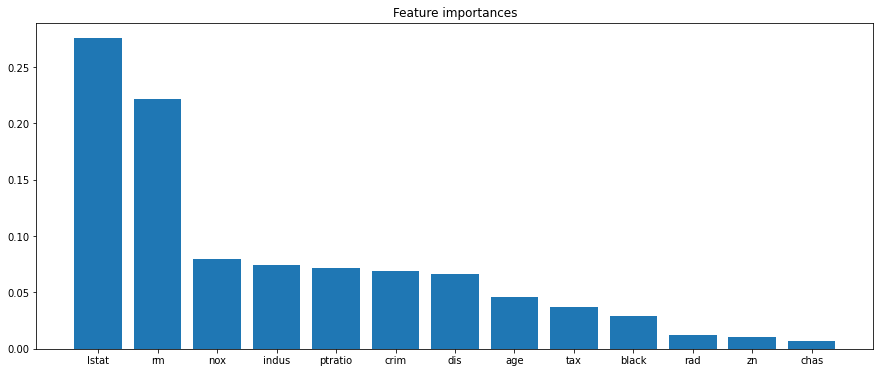

In [163]:
importances = pd.Series({col: model.feature_importances_[i] for i, col in enumerate(train_X.columns)})
importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances.index, importances)
ax.set_title('Feature importances')

In [180]:
model = ensemble.AdaBoostRegressor(
    base_estimator=tree.DecisionTreeRegressor(max_depth=4),
    random_state=seed, n_estimators=5000, learning_rate=.1
)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

MSE: 11.1052


Text(0.5, 1.0, 'Feature importances')

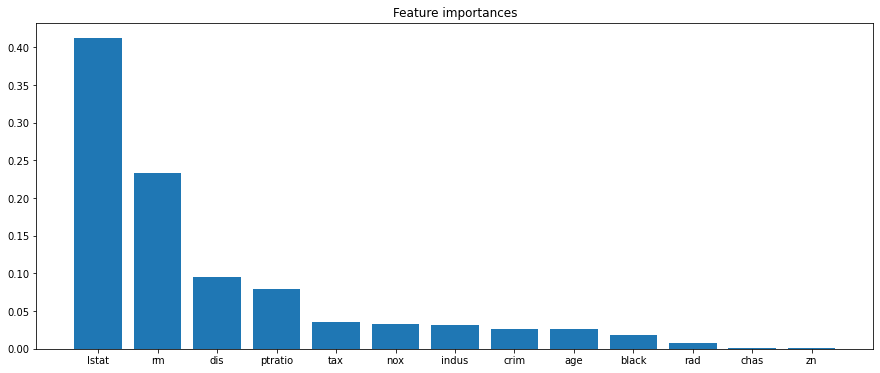

In [176]:
importances = pd.Series({col: model.feature_importances_[i] for i, col in enumerate(train_X.columns)})
importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances.index, importances)
ax.set_title('Feature importances')

In [177]:
model = ensemble.GradientBoostingRegressor(max_depth=4, random_state=seed, n_estimators=5000)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

mse = mean_squared_error(test_y, pred_y)

print(f'MSE: {mse:.4f}')

MSE: 7.4311


Text(0.5, 1.0, 'Feature importances')

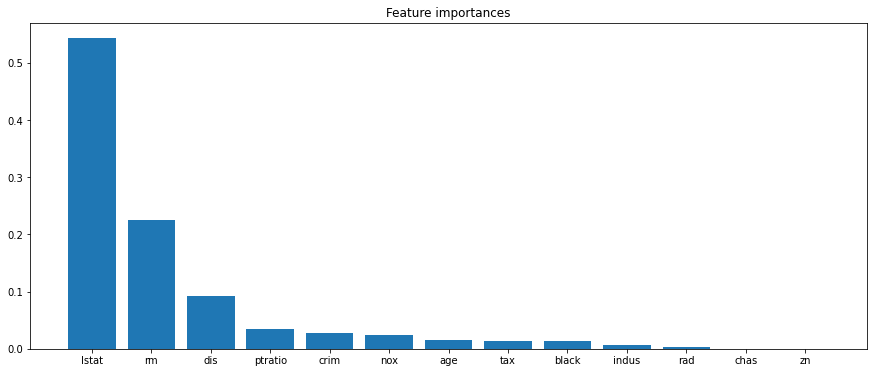

In [178]:
importances = pd.Series({col: model.feature_importances_[i] for i, col in enumerate(train_X.columns)})
importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(importances.index, importances)
ax.set_title('Feature importances')